# Imports

In [2]:
import kwant
print(kwant.version.version)
import kwant.continuum
import numpy as np
import matplotlib.pyplot as plt
from src.make_system import hamiltonian, make_system, barrier_region

import warnings
warnings.filterwarnings('ignore')

1.4.2


ModuleNotFoundError: No module named 'src.make_system'

In [3]:
a = 2000 # nm

a_x=2000 # lattice constant along wire direction in angs
a_y=2000
a_z=2000

w = 7 * a
c_l = 20 * a
b_l = 1 * a
h = 2 * a

In [4]:
ham_normal_discretized = kwant.continuum.discretize(hamiltonian(True, True, False), coords="xyz", grid=a)
ham_all_discretized = kwant.continuum.discretize(hamiltonian(True, True, True), coords="xyz", grid=a)

syst = make_system(w, h, c_l, b_l, ham_all_discretized, ham_normal_discretized,a)
systf = syst.finalized()
plot = kwant.plot(syst, show=True, site_color=lambda s: "y" if barrier_region(s, w, h, c_l, b_l) else "b")

NameError: name 'hamiltonian' is not defined

# Band structure calculation for different values of coupling (optimized to find minimal gap in spectrum)

## Define parameters

In [5]:
params = dict(
    A=2.01,#eVnm^2
    g=10,
    mu_B=57.9e-6,#eV/T
    alpha=3.2,#eVnm
    delta= 180.0E-6,#eV
    mu=0,#eV
    B=0,#T
    coupling_delta=0.21E-3, # In their paper they have a superconducting pairing (electron/hole only) and a spin orbit coupling_delta.
    coupling_alpha=0,#0.19E-3
)

## From workshop

First we do the analytical (I think) version

In [6]:
import ipywidgets

def interact(function, **params):
    """A convenience function for varying parameters."""
    params_spec = {
        key: ipywidgets.FloatText(value=value, step=0.05)
        for key, value in params.items()
    }
    return ipywidgets.interactive(function, **params_spec)

In [7]:
majorana_hamiltonian = hamiltonian(True, True, False)

NameError: name 'hamiltonian' is not defined

In [8]:
h_cont = kwant.continuum.lambdify(majorana_hamiltonian)

NameError: name 'majorana_hamiltonian' is not defined

In [9]:
majorana_hamiltonian

NameError: name 'majorana_hamiltonian' is not defined

In [10]:
momenta = np.linspace(-4, 4, 100)

def plot_spectrum(**params):
    kwant.plotter.spectrum(h_cont, ('k_x', momenta), params=params)
    
interact(
    plot_spectrum,
    A=2.01,#eVnm^2
    g=10,
    mu_B=57.9e-6,#eV/T
    B=0,
    mu=0,
    alpha=3.2,
    k_y=0,
    delta=180e-6
)

interactive(children=(FloatText(value=2.01, description='A', step=0.05), FloatText(value=10.0, description='g'…

Next we do the tight-binding model version

In [11]:
ham_normal_discretized = kwant.continuum.discretize(hamiltonian(True, True, False), coords="xyz")

NameError: name 'hamiltonian' is not defined

In [12]:
infinite_wire = kwant.wraparound.wraparound(ham_normal_discretized).finalized()

def spectrum_discrete(**params):
    kwant.plotter.spectrum(
        infinite_wire,
        ('k_x', np.linspace(-np.pi, np.pi, 301)),
        params=params,
    )

interact(
    spectrum_discrete,
    A=1,#eVnm^2
    g=2,
    mu_B=1,#eV/T
    B=0,
    mu=0.3,
    alpha=0.3,
    delta=0,
    k_y=0,
    k_z=0
)

NameError: name 'ham_normal_discretized' is not defined

## Imports

In [13]:
import itertools as it
import adaptive
adaptive.notebook_extension()
from concurrent.futures import ProcessPoolExecutor

ModuleNotFoundError: No module named 'adaptive'

In [14]:
ind_lead_bands = 0 # Defines the lead
kbounds = (-np.pi, np.pi)
#kbounds = (0.0,0.19)

coupling_delta_min = 0
coupling_delta_max = 0.21E-3
coupling_delta_npoints = 5

coupling_alpha_min = 0
coupling_alpha_max = 0.19E-3
coupling_alpha_npoints = 3

coupling_delta_list = np.linspace(coupling_delta_min, coupling_delta_max, num=coupling_delta_npoints)
coupling_alpha_list = np.linspace(coupling_alpha_min, coupling_alpha_max, num=coupling_alpha_npoints)

mu_min = 0
mu_max = 1e-3
mu_npoints = 10

B_min = 0
B_max = 1
B_npoints = 10

mu_list = np.linspace(mu_min, mu_max, num=mu_npoints)
B_list = np.linspace(B_min, B_max, num=B_npoints)


bands_sim_params = {
    'mu': mu_list,
    'B': B_list,
    'coupling_delta': coupling_delta_list
}

sim_params_list = list(it.product(*bands_sim_params.values()))
bands_list = [kwant.physics.Bands(systf.leads[ind_lead_bands],
                                  params=dict(params,
                                              mu=sim_params[0],
                                              B=sim_params[1],
                                              coupling_delta=sim_params[2]
                                                    ))
              for sim_params in sim_params_list]

NameError: name 'systf' is not defined

In [15]:
def bands_wrapper(k, mu, B, coupling_delta):
    return bands_list[sim_params_list.index((mu, B, coupling_delta))](k)

def goal(l):
    return all([(learner.npoints > 60) for learner in l.learners])

def abs_min_log_loss(xs, ys):
    from adaptive.learner.learner1D import default_loss
    ys = [np.log(np.abs(y).min()) for y in ys]
    return default_loss(xs, ys)

bands_learner = adaptive.BalancingLearner.from_product(
    bands_wrapper, 
    adaptive.Learner1D,
    dict(bounds=kbounds, loss_per_interval=abs_min_log_loss), 
    bands_sim_params
)

executor = ProcessPoolExecutor(max_workers=1)
bands_runner = adaptive.Runner(bands_learner, executor=executor, goal=goal)
bands_runner.live_info()

NameError: name 'adaptive' is not defined

In [16]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

def bands_plotter(learner):
    plot = learner.plot(scatter_or_line='line')
    dims = dict(
        x=hv.Dimension(('k', 'k'), unit='1/a'), 
        y=hv.Dimension(('E', 'E'), unit='eV', range=(-0.001, 0.001))#(-0.15/2, 0.15/2))
    )

    return plot.Path.I.redim(**dims).opts(height=500, width=500)

ModuleNotFoundError: No module named 'holoviews'

In [17]:
bands_learner.plot(plotter=bands_plotter,
                   dynamic=False)

NameError: name 'bands_learner' is not defined

# Band crossings

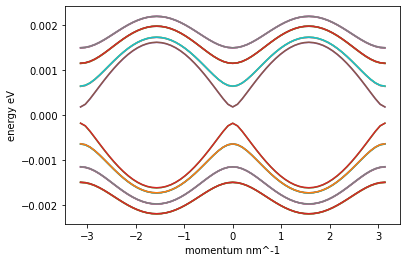

In [18]:
kwant.plotter.bands(systf.leads[0], show=False, params=dict(params,B=0.0,mu=0e-4))
plt.xlabel("momentum nm^-1")
plt.ylabel("energy eV")
plt.show()

In [19]:
import matplotlib as mpl

Bfields=np.linspace(0,2,200)
Vdata = []
energies = np.linspace(-0.004,0.004,50)
for e in energies:
    E_data=[]
    for B in Bfields:
        plt.rcParams["figure.figsize"]= (8,5)  
        mode_info = systf.leads[ind_lead_bands].modes(energy=e, params=dict(params, B=B))
        #smatrix = kwant.smatrix(syst,  params = dict(m_z = B))
        E_data.append((mode_info[0].block_nmodes[0]))  
            
    Vdata.append(E_data)

C:\Users\mhynes\Miniconda3\lib\site-packages\kwant\system.py:316: UserWarning: Hamiltonian breaks Conservation law, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +
C:\Users\mhynes\Miniconda3\lib\site-packages\kwant\system.py:316: UserWarning: Hamiltonian breaks Particle-hole, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +


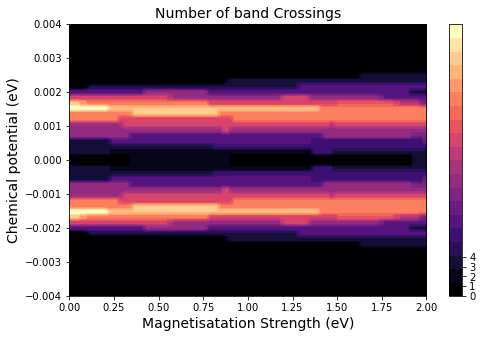

In [20]:
cbar = mpl.cm.get_cmap("magma", 20 )
            
plt.imshow(Vdata, aspect = 'auto',extent = [min(Bfields), max(Bfields), min(energies), max(energies)], cmap=cbar)
plt.xlabel("Magnetisatation Strength (eV)", fontsize=14)



#cbar.set_label("no of band crossings")
plt.ylabel("Chemical potential (eV)", fontsize=14)
plt.colorbar(ticks=np.linspace(0,4,5))
plt.title('Number of band Crossings', fontsize=14 )
plt.show()

# Other various plots

In [21]:
energies = []
data = []
for ie in range(100):
    energy = ie * 0.1

    # compute the scattering matrix at a given energy
    smatrix = kwant.smatrix(systf, energy,params=params)

    # compute the transmission probability from lead 0 to
    # lead 1
    energies.append(energy)
    data.append(smatrix.transmission(1, 2))

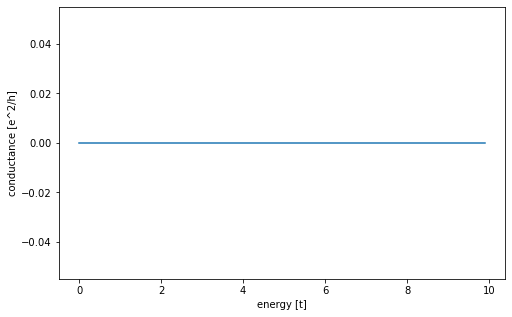

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(energies, data)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
plt.show()

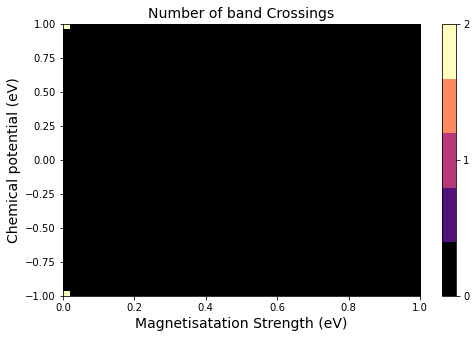

In [23]:
import matplotlib as mpl

Bfields=np.linspace(0,1,50)
Vdata = []
energies = np.linspace(-1,1,50)
for e in energies:
    E_data=[]
    for B in Bfields:
        plt.rcParams["figure.figsize"]= (8,5)  
        mode_info = systf.leads[0].modes(energy=e, params=dict(params, B=B, mu=1))
        #smatrix = kwant.smatrix(syst,  params = dict(m_z = B))
        E_data.append((mode_info[0].block_nmodes[0]))  
            
    Vdata.append(E_data)
     
cbar = mpl.cm.get_cmap("magma", 5 )
            
plt.imshow(Vdata, aspect = 'auto',extent = [min(Bfields), max(Bfields), min(energies), max(energies)], cmap=cbar)
plt.xlabel("Magnetisatation Strength (eV)", fontsize=14)



#cbar.set_label("no of band crossings")
plt.ylabel("Chemical potential (eV)", fontsize=14)
plt.colorbar(ticks=np.linspace(0,4,5))
plt.title('Number of band Crossings', fontsize=14 )
plt.show()

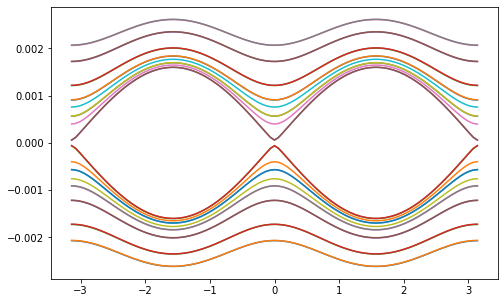

In [24]:
import pathlib

folder = 'B=2_with_rashba_with_superconductivity'
pathlib.Path('./data/' + folder).mkdir(parents=True, exist_ok=True)
momenta = np.linspace(-np.pi, np.pi, 101)
bands = kwant.physics.Bands(systf.leads[0], params=dict(params,B=2))
energies = [bands(k) for k in momenta]
np.savetxt('./data/' + folder + '/momenta.txt', momenta)
np.savetxt('./data/' + folder + '/energies.txt',energies)
plt.plot(momenta,energies)
plt.savefig('./data/' + folder + '/spectrum.png')

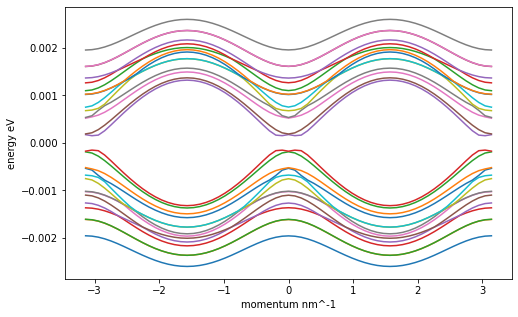

In [25]:
kwant.plotter.bands(systf.leads[0], show=False, params=dict(params,B=0.6,mu=3e-4))
plt.xlabel("momentum nm^-1")
plt.ylabel("energy eV")
plt.show()

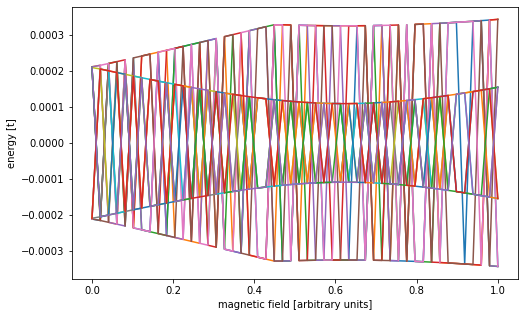

In [26]:
import scipy.sparse.linalg as sla

def plot_spectrum(syst, Bfields):

    energies = []
    for B in Bfields:
        # Obtain the Hamiltonian as a sparse matrix
        ham_mat = syst.hamiltonian_submatrix(params=dict(params, B=B), sparse=True)

        # we only calculate the 15 lowest eigenvalues
        ev = sla.eigsh(ham_mat.tocsc(), k=15, sigma=0,
                       return_eigenvectors=False)

        energies.append(ev)

    plt.figure()
    plt.plot(Bfields, energies)
    plt.xlabel("magnetic field [arbitrary units]")
    plt.ylabel("energy [t]")
    plt.show()

plot_spectrum(systf, Bfields)

In [27]:
## Need to define a function for sorting eigenvalues.

def plot_wave_function(syst, B=0.001):
    # Calculate the wave functions in the system.
    ham_mat = syst.hamiltonian_submatrix(sparse=True, params=dict(params, B=B))
    evals, evecs = sorted_eigs(sla.eigsh(ham_mat.tocsc(), k=20, sigma=0))

    # Plot the probability density of the 10th eigenmode.
    kwant.plotter.map(syst, np.abs(evecs[:, 9])**2,
                      colorbar=False, oversampling=1)

#plot_wave_function(systf)

In [28]:
wf = kwant.wave_function(systf, energy=0, params=params)
psi = wf(1)
rho = kwant.operator.Density(systf)
psi
#density = rho(psi)
#density

C:\Users\mhynes\Miniconda3\lib\site-packages\kwant\system.py:316: UserWarning: Hamiltonian breaks Conservation law, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +
C:\Users\mhynes\Miniconda3\lib\site-packages\kwant\system.py:316: UserWarning: Hamiltonian breaks Particle-hole, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +


array([], shape=(0, 1232), dtype=float64)